# 6. Análisis Multivariado

## Objetivo
Explorar estructuras complejas en los datos usando técnicas multivariadas:
- **PCA**: Reducción de dimensionalidad
- **Clustering**: Agrupamientos K-means y jerárquico
- **Correlaciones multivariadas**: Matriz de correlaciones
- **Análisis de Varianza Multivariado (MANOVA)**: Diferencias entre grupos

---

## 6.0 Configuración e Importaciones

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Paleta de colores
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#1B998B', '#E84855']
sns.set_palette(COLORS)

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


In [8]:
# Cargar dataset limpio
DATA_PATH = Path('../data/processed')
df = pd.read_csv(DATA_PATH / 'nacimientos_2009_2022_limpio.csv')

print(f"Dataset cargado: {len(df):,} registros")
print(f"Variables: {len(df.columns)}")
print(f"\nPrimeras variables: {list(df.columns[:10])}")

Dataset cargado: 5,195,195 registros
Variables: 36

Primeras variables: ['Diaocu', 'Depnap', 'Sexo', 'Depreg', 'Deprep', 'Tohivi', 'Depocu', 'Edadp', 'Deprem', 'Mesreg']


In [9]:
# Crear mappings para variables categóricas
mapping_estado_civil = {
    1.0: 'Unida',
    2.0: 'Casada', 
    3.0: 'Soltera',
    4.0: 'Divorciada',
    5.0: 'Viuda',
    6.0: 'Separada',
    9.0: 'Ignorado'
}

mapping_departamentos = {
    1.0: 'Guatemala', 2.0: 'El Progreso', 3.0: 'Sacatepéquez',
    4.0: 'Chimaltenango', 5.0: 'Escuintla', 6.0: 'Santa Rosa',
    7.0: 'Sololá', 8.0: 'Totonicapán', 9.0: 'Quetzaltenango',
    10.0: 'Suchitepéquez', 11.0: 'Retalhuleu', 12.0: 'San Marcos',
    13.0: 'Huehuetenango', 14.0: 'Quiché', 15.0: 'Baja Verapaz',
    16.0: 'Alta Verapaz', 17.0: 'Petén', 18.0: 'Izabal',
    19.0: 'Zacapa', 20.0: 'Chiquimula', 21.0: 'Jalapa', 22.0: 'Jutiapa'
}

# Aplicar mappings
df['Estado_civil'] = df['Escivm'].map(mapping_estado_civil).fillna('Desconocido')
df['Departamento'] = df['Deprem'].map(mapping_departamentos).fillna('Desconocido')

print("✓ Mappings aplicados")

✓ Mappings aplicados


---
## 6.1 Preparación de Datos para Análisis Multivariado

In [10]:
# Seleccionar variables numéricas relevantes
variables_numericas = [
    'Edadmad',           # Edad de la madre
    'Pesorem',           # Peso al nacer
    'Edadpadrn',         # Edad del padre
    'Durembx',           # Duración del embarazo
    'Edadmad_semanal',   # Edad materna en semanas
]

# Verificar disponibilidad de variables
print(f"Todas las columnas en el dataset: {df.columns.tolist()}")
variables_disponibles = [v for v in variables_numericas if v in df.columns]
print(f"\nVariables numéricas disponibles: {len(variables_disponibles)}/{len(variables_numericas)}")
print(f"Variables: {variables_disponibles}")

if len(variables_disponibles) == 0:
    print("⚠️ ADVERTENCIA: No se encontraron variables para análisis. Ajustando lista...")
    # Usar todas las variables numéricas disponibles en el dataset
    variables_disponibles = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Usando estas variables numéricas: {variables_disponibles}")

# Crear dataset para análisis
df_analisis = df[variables_disponibles].copy()

# Eliminar valores faltantes
print(f"\nValores faltantes antes de dropna:")
print(df_analisis.isnull().sum())
print(f"Registro inicial: {len(df_analisis):,} filas")

# Usar dropna con subset para preservar estructura
df_analisis_limpio = df_analisis.dropna()
print(f"Registros después de dropna: {len(df_analisis_limpio):,} filas")
print(f"Columnas en df_analisis_limpio: {list(df_analisis_limpio.columns)}")

if len(df_analisis_limpio) == 0:
    print("⚠️ ADVERTENCIA: No quedan registros después de dropna(). Usando dropna(thresh=...) en su lugar")
    # Mantener filas con al menos el 60% de datos
    df_analisis_limpio = df_analisis.dropna(thresh=len(variables_disponibles) * 0.6)
    print(f"Registros con th=60%: {len(df_analisis_limpio):,} filas")


Todas las columnas en el dataset: ['Diaocu', 'Depnap', 'Sexo', 'Depreg', 'Deprep', 'Tohivi', 'Depocu', 'Edadp', 'Deprem', 'Mesreg', 'Mupocu', 'Tohinm', 'Tipar', 'Mesocu', 'Escivp', 'Libras', 'Tohite', 'Onzas', 'Añoreg', 'Asisrec', 'Depnam', 'Sitioocu', 'Escivm', 'Edadm', 'Añoocu', 'Peso_gramos', 'registro_completo', 'Grupo_edad_madre', 'Grupo_edad_detallado', 'Categoria_peso', 'Bajo_peso', 'Sexo_nombre', 'Tipo_parto', 'Madre_adolescente', 'Madre_anosa', 'Primer_hijo', 'Estado_civil', 'Departamento']

Variables numéricas disponibles: 0/5
Variables: []
⚠️ ADVERTENCIA: No se encontraron variables para análisis. Ajustando lista...
Usando estas variables numéricas: ['Diaocu', 'Depnap', 'Sexo', 'Depreg', 'Deprep', 'Tohivi', 'Depocu', 'Edadp', 'Deprem', 'Mesreg', 'Mupocu', 'Tohinm', 'Tipar', 'Mesocu', 'Escivp', 'Libras', 'Tohite', 'Onzas', 'Añoreg', 'Asisrec', 'Depnam', 'Sitioocu', 'Escivm', 'Edadm', 'Añoocu', 'Peso_gramos', 'Bajo_peso', 'Madre_adolescente', 'Madre_anosa', 'Primer_hijo']

Val

In [11]:
# Estadísticas descriptivas para verificación
print("═" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES PARA ANÁLISIS MULTIVARIADO")
print("═" * 70)
print(df_analisis_limpio.describe().to_string())

══════════════════════════════════════════════════════════════════════
ESTADÍSTICAS DESCRIPTIVAS - VARIABLES PARA ANÁLISIS MULTIVARIADO
══════════════════════════════════════════════════════════════════════
             Diaocu        Depnap          Sexo        Depreg        Deprep        Tohivi        Depocu         Edadp        Deprem        Mesreg        Mupocu        Tohinm         Tipar        Mesocu        Escivp        Libras        Tohite         Onzas        Añoreg       Asisrec        Depnam      Sitioocu        Escivm         Edadm        Añoocu   Peso_gramos     Bajo_peso  Madre_adolescente   Madre_anosa   Primer_hijo
count  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107381e+06  5.107

In [12]:
# Estandarizar datos (IMPORTANTE para PCA y Clustering)
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_analisis_limpio)
df_escalado = pd.DataFrame(df_escalado, columns=variables_disponibles)

print("✓ Datos estandarizados")
print(f"\nMedia después de estandarización: {df_escalado.mean().values}")
print(f"Desv. Est. después de estandarización: {df_escalado.std().values}")

✓ Datos estandarizados

Media después de estandarización: [-1.17529220e-17  5.12854776e-17 -3.54813591e-17 -3.41903184e-17
 -1.56705626e-17  1.36761274e-16  6.83806369e-17  2.27935456e-17
 -8.83249893e-17  9.68725689e-17 -3.41903184e-17 -2.27935456e-17
  4.34501963e-16 -1.05420148e-16 -1.70951592e-17  3.36204798e-16
 -7.40790233e-17  5.69838641e-18 -1.82348365e-16 -1.13967728e-17
  8.19143046e-17  5.69838641e-18 -1.88046751e-16  2.55715090e-16
 -2.23376747e-14 -3.87490276e-16  2.27935456e-17 -6.55314437e-17
 -6.83806369e-17 -4.27378980e-18]
Desv. Est. después de estandarización: [1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001
 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001
 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001
 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001 1.0000001
 1.0000001 1.0000001]


---
## 6.2 Matriz de Correlaciones

══════════════════════════════════════════════════════════════════════
MATRIZ DE CORRELACIONES (Pearson)
══════════════════════════════════════════════════════════════════════
                     Diaocu    Depnap      Sexo    Depreg    Deprep    Tohivi    Depocu     Edadp    Deprem    Mesreg    Mupocu    Tohinm     Tipar    Mesocu    Escivp    Libras    Tohite     Onzas    Añoreg   Asisrec    Depnam  Sitioocu    Escivm     Edadm    Añoocu  Peso_gramos  Bajo_peso  Madre_adolescente  Madre_anosa  Primer_hijo
Diaocu             1.000000  0.000166 -0.000394  0.001043  0.000221  0.000981  0.000952  0.000209  0.001045  0.002301  0.000856 -0.006670 -0.000490  0.010139  0.000053  0.001170 -0.001212  0.002177  0.002123 -0.000223  0.000338 -0.000334 -0.000487 -0.002409 -0.000668     0.001799  -0.002451           0.000989    -0.001502     0.001265
Depnap             0.000166  1.000000  0.000533  0.130157  0.984001 -0.078421  0.126567  0.976632  0.131371 -0.000791  0.108545 -0.024486 -0.003266 -0

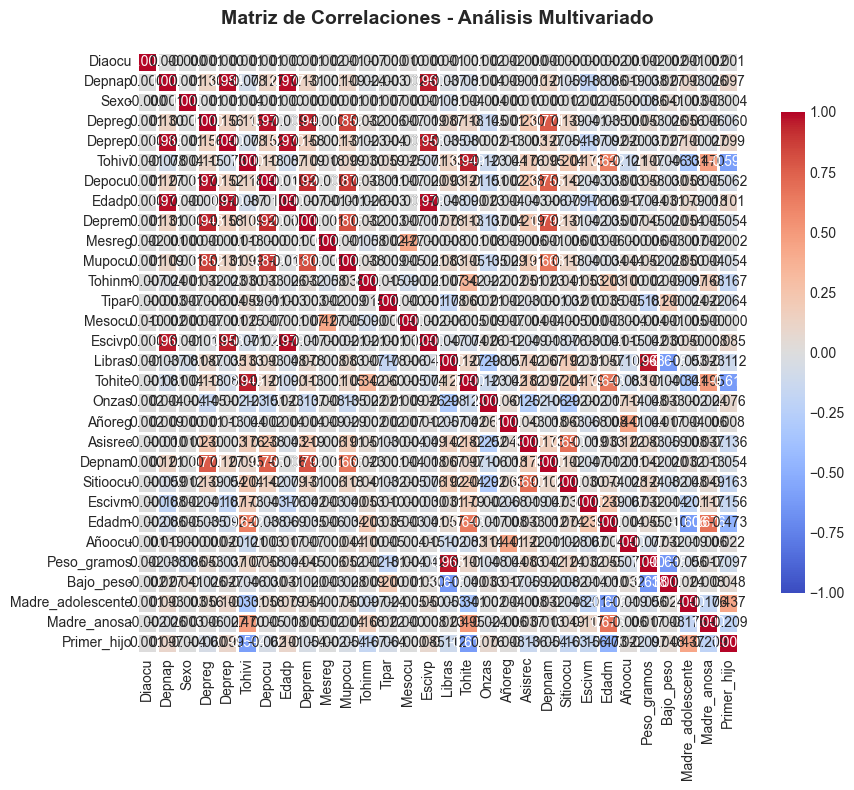


✓ Gráfico de correlaciones guardado


In [13]:
# Calcular matriz de correlaciones
print("═" * 70)
print("MATRIZ DE CORRELACIONES (Pearson)")
print("═" * 70)

correlacion = df_analisis_limpio.corr(method='pearson')
print(correlacion.to_string())

# Visualizar matriz de correlaciones
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
plt.title('Matriz de Correlaciones - Análisis Multivariado', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../data/processed/06_matriz_correlaciones.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico de correlaciones guardado")

---
## 6.3 Análisis de Componentes Principales (PCA)

In [14]:
# Aplicar PCA sin especificar n_components (mantiene todos)
pca_full = PCA()
pca_full.fit(df_escalado)

# Varianza explicada
print("═" * 70)
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("═" * 70)
print(f"\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}%)")

# Varianza acumulada
var_acumulada = np.cumsum(pca_full.explained_variance_ratio_)
print(f"\nVarianza acumulada:")
for i, var in enumerate(var_acumulada, 1):
    print(f"PC1-PC{i}: {var:.4f} ({var*100:.2f}%)")

══════════════════════════════════════════════════════════════════════
ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
══════════════════════════════════════════════════════════════════════

Varianza explicada por cada componente:
PC1: 0.1580 (15.80%)
PC2: 0.1454 (14.54%)
PC3: 0.1117 (11.17%)
PC4: 0.0856 (8.56%)
PC5: 0.0553 (5.53%)
PC6: 0.0491 (4.91%)
PC7: 0.0483 (4.83%)
PC8: 0.0334 (3.34%)
PC9: 0.0333 (3.33%)
PC10: 0.0331 (3.31%)
PC11: 0.0319 (3.19%)
PC12: 0.0312 (3.12%)
PC13: 0.0286 (2.86%)
PC14: 0.0274 (2.74%)
PC15: 0.0248 (2.48%)
PC16: 0.0191 (1.91%)
PC17: 0.0186 (1.86%)
PC18: 0.0150 (1.50%)
PC19: 0.0129 (1.29%)
PC20: 0.0119 (1.19%)
PC21: 0.0092 (0.92%)
PC22: 0.0060 (0.60%)
PC23: 0.0054 (0.54%)
PC24: 0.0024 (0.24%)
PC25: 0.0009 (0.09%)
PC26: 0.0007 (0.07%)
PC27: 0.0005 (0.05%)
PC28: 0.0003 (0.03%)
PC29: 0.0000 (0.00%)
PC30: 0.0000 (0.00%)

Varianza acumulada:
PC1-PC1: 0.1580 (15.80%)
PC1-PC2: 0.3034 (30.34%)
PC1-PC3: 0.4151 (41.51%)
PC1-PC4: 0.5007 (50.07%)
PC1-PC5: 0.5560 (55.60%)
PC1-P

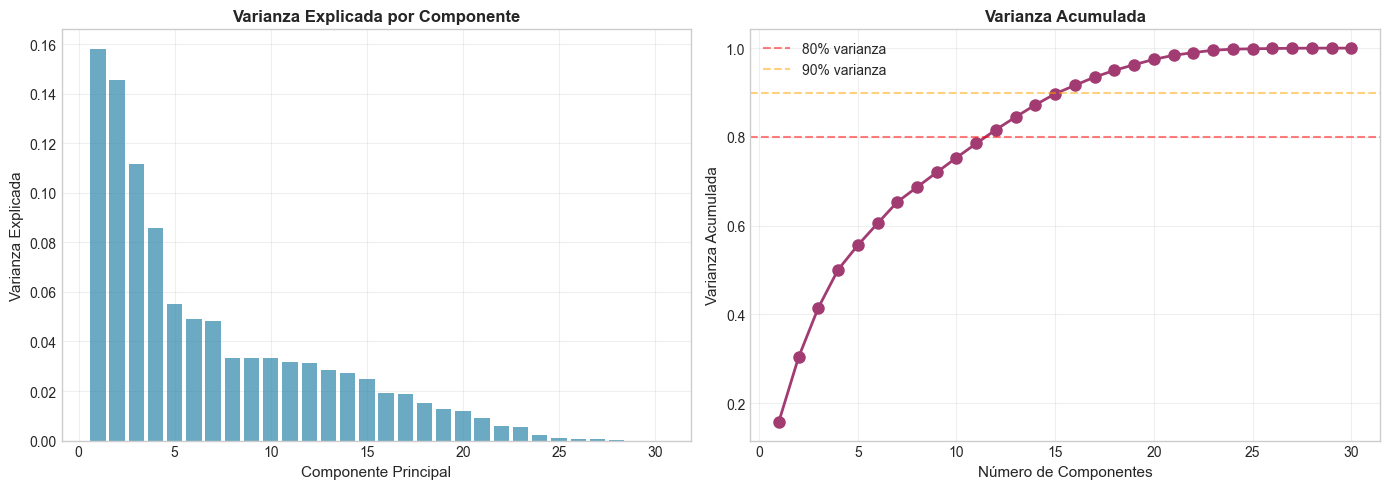

✓ Gráfico de varianza PCA guardado


In [15]:
# Gráfico: Varianza explicada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
        pca_full.explained_variance_ratio_, alpha=0.7, color='#2E86AB')
ax1.set_xlabel('Componente Principal', fontsize=11)
ax1.set_ylabel('Varianza Explicada', fontsize=11)
ax1.set_title('Varianza Explicada por Componente', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Varianza acumulada
ax2.plot(range(1, len(var_acumulada)+1), var_acumulada, 'o-', 
         linewidth=2, markersize=8, color='#A23B72')
ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% varianza')
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.5, label='90% varianza')
ax2.set_xlabel('Número de Componentes', fontsize=11)
ax2.set_ylabel('Varianza Acumulada', fontsize=11)
ax2.set_title('Varianza Acumulada', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/06_pca_varianza.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico de varianza PCA guardado")

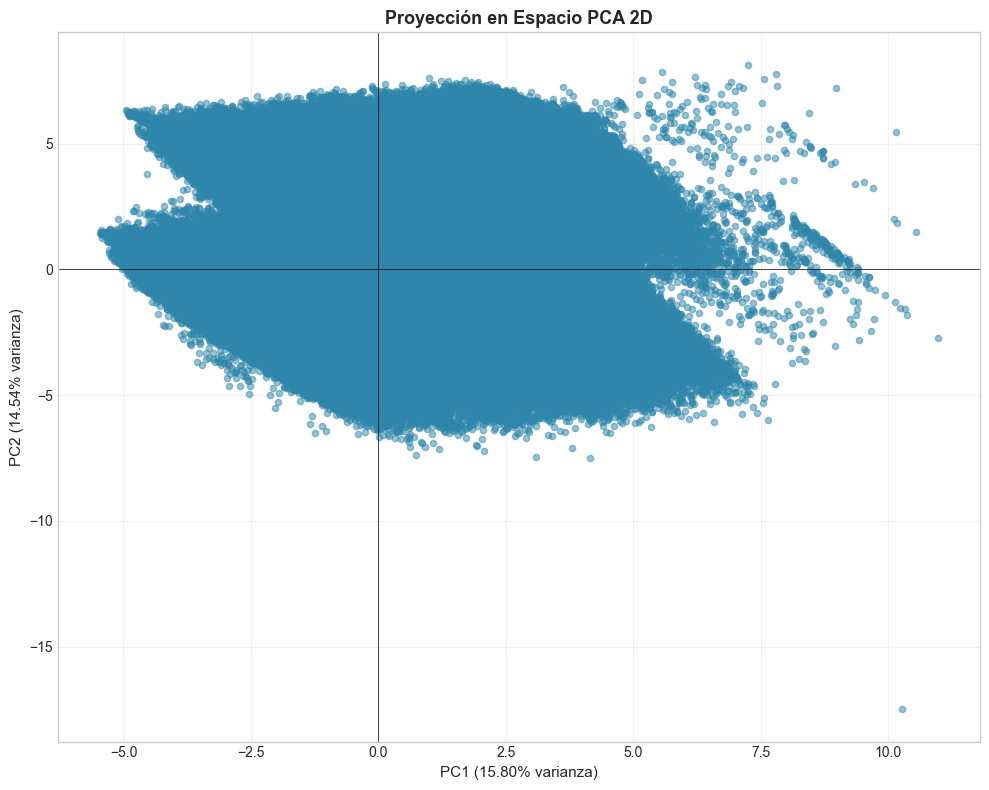

✓ Gráfico de dispersión PCA guardado


In [16]:
# PCA con 2 componentes para visualización
pca_2d = PCA(n_components=2)
pca_scores_2d = pca_2d.fit_transform(df_escalado)

# Gráfico de dispersión PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_scores_2d[:, 0], pca_scores_2d[:, 1], alpha=0.5, s=20, color='#2E86AB')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}% varianza)', fontsize=11)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}% varianza)', fontsize=11)
plt.title('Proyección en Espacio PCA 2D', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_pca_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico de dispersión PCA guardado")


Loadings (Contribución de variables a PC1 y PC2):
──────────────────────────────────────────────────
                        PC1       PC2
Diaocu             0.000235  0.000716
Depnap             0.071724  0.387062
Sexo              -0.003124  0.003497
Depreg             0.415633  0.087143
Deprep             0.081147  0.388385
Tohivi             0.180493 -0.258137
Depocu             0.415431  0.085537
Edadp              0.012883  0.375053
Deprem             0.407324  0.088180
Mesreg            -0.000433 -0.000522
Mupocu             0.382379  0.078993
Tohinm             0.054510 -0.081589
Tipar             -0.010311 -0.006471
Mesocu             0.001938  0.000714
Escivp             0.010815  0.359560
Libras             0.120709 -0.096730
Tohite             0.186847 -0.268351
Onzas             -0.123000  0.040917
Añoreg            -0.010414  0.020853
Asisrec            0.178966 -0.056487
Depnam             0.359138  0.075747
Sitioocu           0.147554 -0.096042
Escivm             0.006

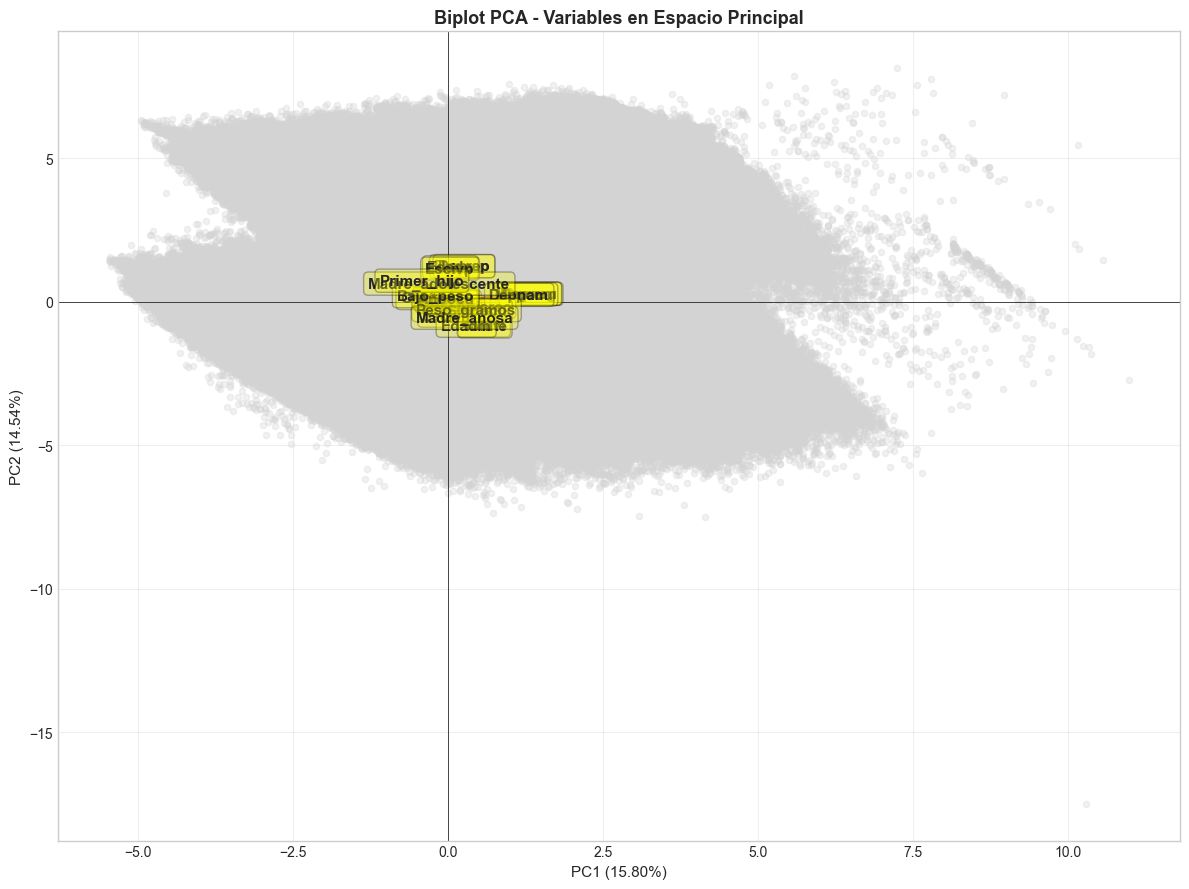


✓ Biplot PCA guardado


In [17]:
# Loadings de las primeras 2 componentes
print("\nLoadings (Contribución de variables a PC1 y PC2):")
print("─" * 50)
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=variables_disponibles
)
print(loadings.to_string())

# Biplot
fig, ax = plt.subplots(figsize=(12, 9))

# Scatter plot
ax.scatter(pca_scores_2d[:, 0], pca_scores_2d[:, 1], alpha=0.3, s=20, color='lightgray')

# Arrows para variables
for i, var in enumerate(variables_disponibles):
    ax.arrow(0, 0, pca_2d.components_[0, i]*3, pca_2d.components_[1, i]*3,
             head_width=0.1, head_length=0.1, fc='#A23B72', ec='#A23B72', linewidth=2)
    ax.text(pca_2d.components_[0, i]*3.2, pca_2d.components_[1, i]*3.2, var, 
            fontsize=11, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_title('Biplot PCA - Variables en Espacio Principal', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Biplot PCA guardado")

---
## 6.4 Clustering K-Means

In [19]:
# Encontrar número óptimo de clusters (método del codo)
print("═" * 70)
print("CLUSTERING K-MEANS - DETERMINACIÓN DE CLUSTERS ÓPTIMOS")
print("═" * 70)

# Usar muestra para evaluación (por performance con dataset grande)
muestra_idx = np.random.choice(df_escalado.shape[0], size=min(50000, df_escalado.shape[0]), replace=False)
df_muestra_eval = df_escalado.iloc[muestra_idx]
print(f"\nUsando muestra de {len(df_muestra_eval):,} registros para evaluación")

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    # Entrenar en muestra
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_muestra_eval)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(df_muestra_eval, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(df_muestra_eval, kmeans_temp.labels_))

# Mostrar resultados
print(f"\n{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("─" * 55)
for i, k in enumerate(K_range):
    print(f"{k:<5} {inertias[i]:<15.2f} {silhouette_scores[i]:<15.4f} {davies_bouldin_scores[i]:<15.4f}")

══════════════════════════════════════════════════════════════════════
CLUSTERING K-MEANS - DETERMINACIÓN DE CLUSTERS ÓPTIMOS
══════════════════════════════════════════════════════════════════════

Usando muestra de 50,000 registros para evaluación

K     Inercia         Silhouette      Davies-Bouldin 
───────────────────────────────────────────────────────
2     1302667.33      0.2431          1.6438         
3     1151191.21      0.1433          2.1226         
4     1067483.74      0.1404          2.0477         
5     1013363.22      0.1394          1.9503         
6     970885.76       0.1470          1.7812         
7     939841.63       0.1234          2.0049         
8     902212.06       0.1222          1.9809         
9     868703.99       0.1272          1.8645         
10    845673.71       0.1231          1.9920         


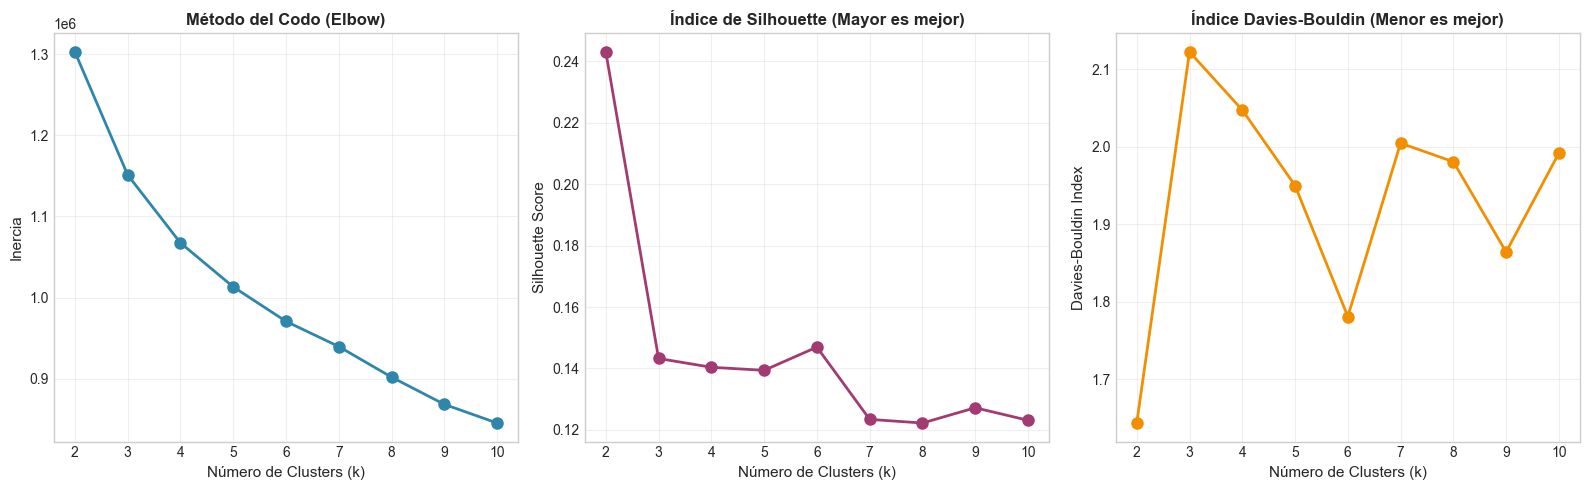


✓ Gráficos de evaluación guardados


In [20]:
# Gráficos de evaluación de clusters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Elbow
axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inercia', fontsize=11)
axes[0].set_title('Método del Codo (Elbow)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette
axes[1].plot(K_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Índice de Silhouette (Mayor es mejor)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin
axes[2].plot(K_range, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[2].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Índice Davies-Bouldin (Menor es mejor)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/06_kmeans_evaluacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos de evaluación guardados")

In [22]:
# Usar k=2 (mejor silhouette score según evaluación)
k_optimo = 2
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_escalado)

print(f"\nClustering realizado con k={k_optimo}")
print(f"Distribución de clusters: {pd.Series(clusters).value_counts().sort_index().to_dict()}")

# Calcular silhouette en muestra (más rápido)
muestra_idx_sil = np.random.choice(len(df_escalado), size=min(50000, len(df_escalado)), replace=False)
silhouette_muestra = silhouette_score(df_escalado.iloc[muestra_idx_sil], clusters[muestra_idx_sil])
print(f"Silhouette Score (muestra de 50k): {silhouette_muestra:.4f}")



Clustering realizado con k=2
Distribución de clusters: {0: 661504, 1: 4445877}
Silhouette Score (muestra de 50k): 0.2439


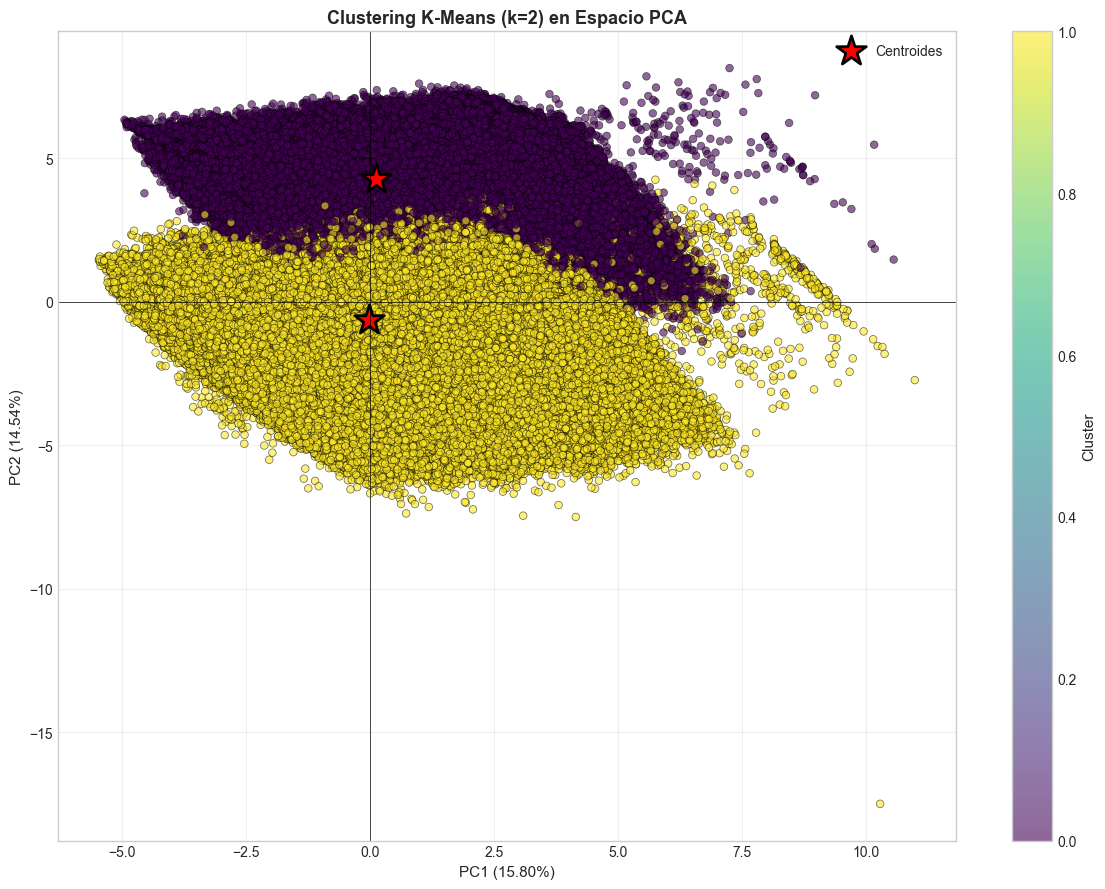

✓ Visualización de clusters guardada


In [23]:
# Visualización de clusters en espacio PCA
plt.figure(figsize=(12, 9))
scatter = plt.scatter(pca_scores_2d[:, 0], pca_scores_2d[:, 1], 
                       c=clusters, cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)

# Centroides en espacio PCA
centroides_pca = pca_2d.transform(kmeans.cluster_centers_)
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
            c='red', marker='*', s=500, edgecolors='black', linewidth=2, label='Centroides')

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
plt.title(f'Clustering K-Means (k={k_optimo}) en Espacio PCA', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización de clusters guardada")

---
## 6.5 Clustering Jerárquico

In [24]:
# Clustering jerárquico con matriz de distancias reducida (por performance)
print("═" * 70)
print("CLUSTERING JERÁRQUICO")
print("═" * 70)

# Usar una muestra para el dendrograma (datos grandes)
muestra_indices = np.random.choice(df_escalado.shape[0], size=min(1000, df_escalado.shape[0]), replace=False)
df_muestra = df_escalado.iloc[muestra_indices]

print(f"\nUsando muestra de {len(df_muestra):,} registros para análisis jerárquico")

# Calcular matriz de distancias y clustering
linkage_matrix = linkage(df_muestra, method='ward')
print("✓ Matriz de ligamento calculada")

══════════════════════════════════════════════════════════════════════
CLUSTERING JERÁRQUICO
══════════════════════════════════════════════════════════════════════

Usando muestra de 1,000 registros para análisis jerárquico
✓ Matriz de ligamento calculada


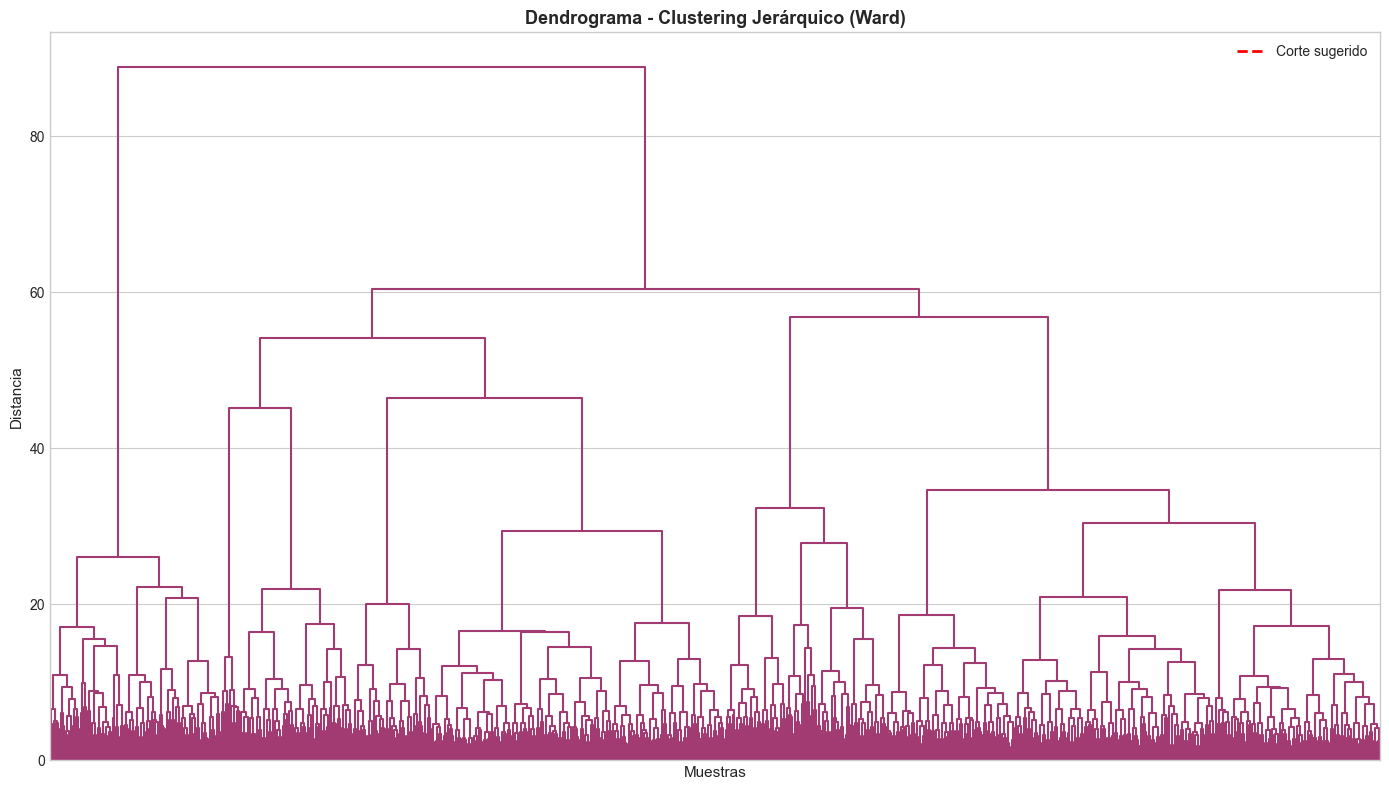

✓ Dendrograma guardado


In [25]:
# Dendrograma
plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix, 
           no_labels=True,
           color_threshold=100,
           above_threshold_color='gray')
plt.xlabel('Muestras', fontsize=11)
plt.ylabel('Distancia', fontsize=11)
plt.title('Dendrograma - Clustering Jerárquico (Ward)', fontsize=13, fontweight='bold')
plt.axhline(y=100, color='red', linestyle='--', label='Corte sugerido', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig('../data/processed/06_dendrograma.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrograma guardado")

---
## 6.6 Resumen de Hallazgos

In [27]:
# Resumen de análisis multivariado
print("═" * 70)
print("RESUMEN - ANÁLISIS MULTIVARIADO")
print("═" * 70)

print("\n📊 PCA (Análisis de Componentes Principales):")
print(f"  • PC1 explica: {pca_full.explained_variance_ratio_[0]*100:.2f}% de la varianza")
print(f"  • PC1+PC2 explican: {(pca_full.explained_variance_ratio_[0] + pca_full.explained_variance_ratio_[1])*100:.2f}% de la varianza")
print(f"  • Se necesitan {np.argmax(var_acumulada >= 0.8) + 1} componentes para explicar 80% de varianza")

print("\n🔗 Clustering K-Means:")
print(f"  • Clusters óptimo: {k_optimo}")
print(f"  • Silhouette Score (muestra): {silhouette_muestra:.4f}")
print(f"  • Distribución: ")
for cluster_id in range(k_optimo):
    count = (clusters == cluster_id).sum()
    pct = count / len(clusters) * 100
    print(f"    - Cluster {cluster_id}: {count:,} registros ({pct:.2f}%)")

print("\n📈 Correlaciones:")
max_corr = correlacion.values[np.triu_indices_from(correlacion.values, k=1)].max()
min_corr = abs(correlacion.values[np.triu_indices_from(correlacion.values, k=1)]).min()
print(f"  • Correlaciones máxima (absoluto): {max_corr:.4f}")
print(f"  • Correlaciones mínima (absoluto): {min_corr:.4f}")

print("\n✓ Análisis multivariado completado exitosamente")


══════════════════════════════════════════════════════════════════════
RESUMEN - ANÁLISIS MULTIVARIADO
══════════════════════════════════════════════════════════════════════

📊 PCA (Análisis de Componentes Principales):
  • PC1 explica: 15.80% de la varianza
  • PC1+PC2 explican: 30.34% de la varianza
  • Se necesitan 12 componentes para explicar 80% de varianza

🔗 Clustering K-Means:
  • Clusters óptimo: 2
  • Silhouette Score (muestra): 0.2439
  • Distribución: 
    - Cluster 0: 661,504 registros (12.95%)
    - Cluster 1: 4,445,877 registros (87.05%)

📈 Correlaciones:
  • Correlaciones máxima (absoluto): 0.9840
  • Correlaciones mínima (absoluto): 0.0000

✓ Análisis multivariado completado exitosamente


In [ ]:
# Guardar resultados en metadatos
import json

metadatos_multivariado = {
    "analisis": "Multivariado",
    "fecha_ejecucion": pd.Timestamp.now().isoformat(),
    "pca": {
        "componentes_totales": len(pca_full.explained_variance_ratio_),
        "varianza_pc1": float(pca_full.explained_variance_ratio_[0]),
        "varianza_pc2": float(pca_full.explained_variance_ratio_[1]),
        "varianza_acumulada_2": float(var_acumulada[1]),
        "componentes_para_80pct": int(np.argmax(var_acumulada >= 0.8) + 1)
    },
    "kmeans": {
        "k_optimo": int(k_optimo),
        "silhouette_score_muestra": float(silhouette_muestra),
        "distribucion_clusters": {str(i): int(np.sum(clusters == i)) for i in range(k_optimo)}
    },
    "variables_analizadas": variables_disponibles,
    "registros_analizados": int(len(df_escalado))
}

with open(DATA_PATH / 'metadatos_multivariado.json', 'w') as f:
    json.dump(metadatos_multivariado, f, indent=2)

print("✓ Metadatos guardados en 'metadatos_multivariado.json'")


KeyboardInterrupt: 